<a href="https://colab.research.google.com/github/jeibloo/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)
# Same for LAND_SQUARE_FEET
df['LAND_SQUARE_FEET'] = (
    df['LAND_SQUARE_FEET']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .fillna(0)
)

In [0]:
df.drop(['EASE-MENT','APARTMENT_NUMBER'],inplace=True,axis='columns')

In [108]:
## Isolate >$100k & <$2mil
price_mask = ((df['SALE_PRICE'] > 100000) &
              (df['SALE_PRICE'] < 2000000))
df = df[price_mask].copy()

## Isolate BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
building_mask = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
df = df[building_mask].copy()

## Then isolate January — March 2019 to train. April 2019 to test.
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)
test = df[df['SALE_DATE'].dt.month == 4].copy()
train_mask = ((df['SALE_DATE'].dt.month <= 3))
train = df[train_mask].copy()
print(test.shape,train.shape)

(644, 19) (2507, 19)


In [109]:
df.profile_report()

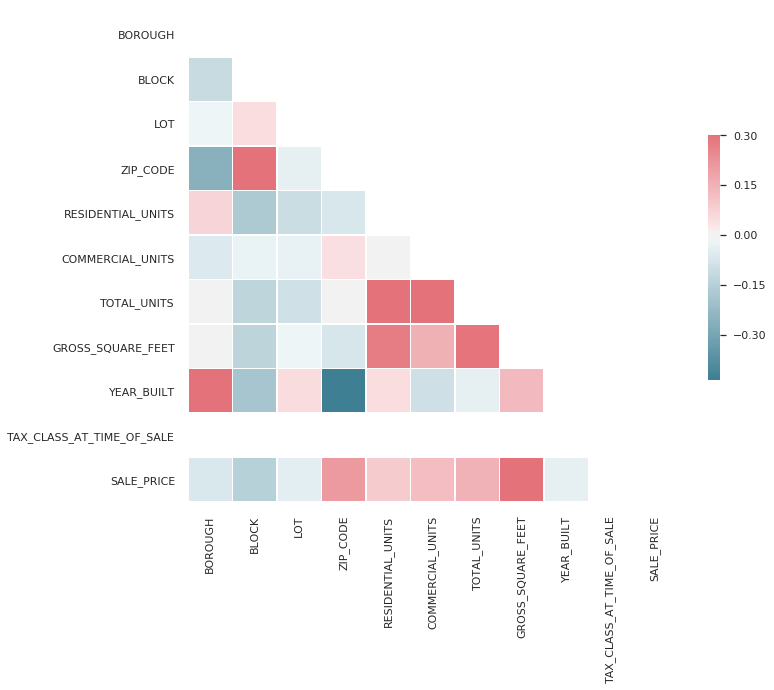

In [110]:
## HEATMAP one-sided
def heatieboi(data):
  from string import ascii_letters
  import numpy as np
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  sns.set(style="white")
  # Compute the correlation matrix
  corr = data.corr()

  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
  plt.show()
  # To assure plot closure
  plt.close()

heatieboi(train)

In [111]:
## Do exploratory visualizations with Seaborn
import plotly.express as px
train_year = train[train['YEAR_BUILT'] > 1000]
px.scatter(train_year,x='YEAR_BUILT',y='SALE_PRICE',color='ZIP_CODE')

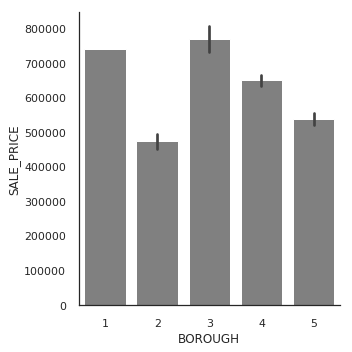

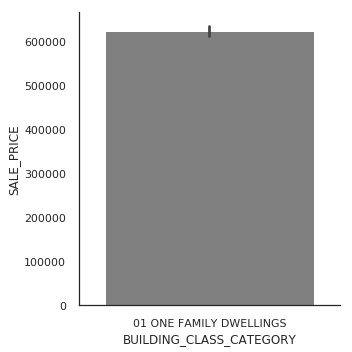

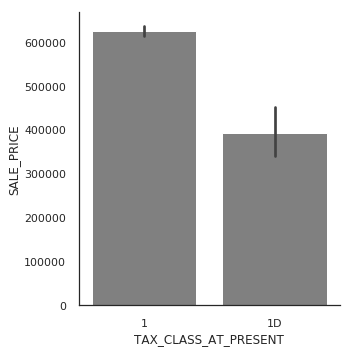

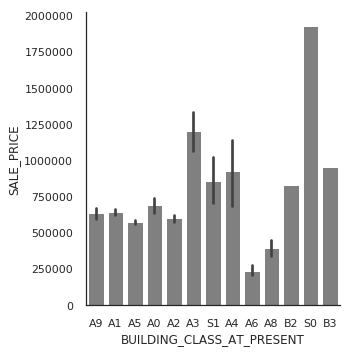

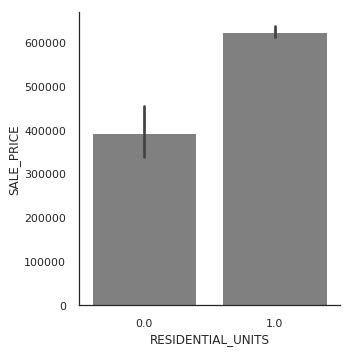

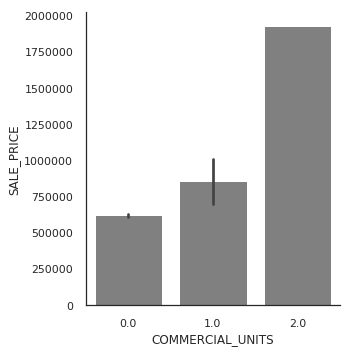

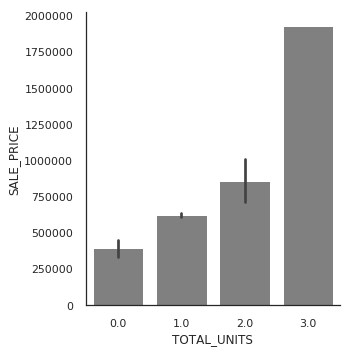

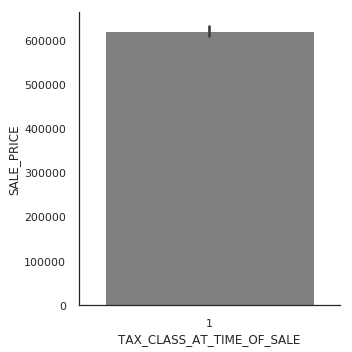

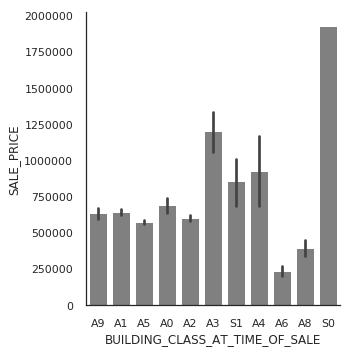

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in (train.columns):
  if train[col].nunique() < 20:
    sns.catplot(x=col,y='SALE_PRICE',data=train,kind='bar',color='grey')
    plt.show()

In [113]:
## Do a one-hot encoding of cats
train.describe(exclude='number').T

,count,unique,top,freq,first,last
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
ADDRESS,2507,2497,216-29 114TH ROAD,2,NaN,NaN
LAND_SQUARE_FEET,2507,887,4000,234,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00


In [114]:
# Making TAX_CLASS_AT_PRESENT a thing might work
train.TAX_CLASS_AT_PRESENT.unique()

array(['1', '1D'], dtype=object)

In [115]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['TAX_CLASS_AT_PRESENT'])
encoded.head()

,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D
44,1,0
61,1,0
78,1,0
108,1,0
111,1,0


In [0]:
from sklearn.preprocessing import StandardScaler

# Put all features in the same place and drop high cardni stuff
target = 'BUILDING_CLASS_CATEGORY'
high_cardinality = ['ADDRESS','LAND_SQUARE_FEET','NEIGHBORHOOD',
                    'BUILDING_CLASS_AT_PRESENT','BUILDING_CLASS_AT_TIME_OF_SALE',
                    'SALE_DATE']
features = train.columns.drop([target]+high_cardinality)

Xtrain = train[features]
ytrain = train[target]

Xtest = test[features]
ytest = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
Xtrain_encoded = encoder.fit_transform(Xtrain)
# Don't need to fit test to anything, just transform so it looks samey
Xtest_encoded = encoder.transform(Xtest)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain_encoded)
Xtest_scaled = scaler.transform(Xtest_encoded)

In [120]:
from sklearn.sklearn.feature_selection import f_regression, SelectKBest

for i in range(1,len(Xtrain.columns)+1):
  print(f'{k} features')
  
  selector = SelectKBest(score_func=f_regression,k=10)
  Xtrain_selected = selector.fit_transform(Xtrain_scaled,ytrain)
  Xtest_selected = selector.transform(Xtest_scaled)
  
  model = LinearRegression()
  model.fit(Xtrain_selected,ytrain)
  
  y_pred = model.predict(Xtest_selected)
  mae = mean_absolute_error(ytest,y_pred)
  print(f'MAE: ${mae:,.0f}\n')

ModuleNotFoundError: ignored